# Trajectory Clustering with Cuspatial

### The task is grouping a set of trajectories in such a way that trajectories in the same group are more similar to each other than to those in other groups.

### It consists of two major components:

1. Similarity Metric
2. Searching Algorithm

### Here we do the clustering task in two separate steps:

1. Calculate the similarity between all trajectory pairs.
2. Apply searching algorithm on the pre-computed similarity matrix. Here we tried two algorithms: AgglomerativeClustering (AC) and DBSCAN.

### The reason to split the cluster task into the two separate steps: 

* Once a similarity metric is chosen, still need to try different hyperparameter combinations of the searching algorithm to get a good clustering result. 

* Calculating the similarity is usually the more computationally intense task and we don't want to re-compute it at each hyperparameter search iteration.

## How Cuspatial helps:

* Cuspatial can significantly accelerate the trajectory similarity metric computation. 

* Currently cuspatial have implemented `Hausdorff distance` between trajectory pairs.

* we are going to use `Hausdorff distance` as the similarity metric in the following experiments.


In [4]:
from skimage import io, transform
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import cv2
import os
import random
from ipywidgets import interact, interactive, fixed
from ipywidgets import *
import time

from scipy.spatial.distance import directed_hausdorff
from sklearn.cluster import AgglomerativeClustering,KMeans,DBSCAN

import cudf
import cuspatial
from matplotlib import gridspec

# LOCUST DATA

### load preprocessed trajectories

Down load preprocessed trajctory pickle file and put it in the current folder: https://drive.google.com/file/d/1GE-_z9HgLp3eV7Lgo_KOl53QuMgiCUMS/view?usp=sharing 

In [5]:
import pickle

with open('trajectories_extracted.p','rb') as f:
    trajectories = pickle.load(f)

### define trajectory transform functions

In [6]:
def convert_latlon_2_image_for_vis_wrongway_intersection(lat,long):

    x_anchor = 436.369
    y_anchor = 126.613
    long_anchor = -90.666714
    lat_anchor = 42.492466

    long_1 = -90.663183
    lat_1 = 42.491671
    x_1 = 971.026
    y_1 = 291.955

    long_2_x_rate = (x_1-x_anchor)/(long_1-long_anchor)
    lat_2_y_rate = (y_1-y_anchor)/(lat_1-lat_anchor)

    y = (lat-lat_anchor)*lat_2_y_rate+y_anchor
    x = (long-long_anchor)*long_2_x_rate+x_anchor

    return x, y

def convert_traj_latlon_2_image_wrongway_intersection(traj):
    """Transform trajectory coordinates to image coordinate."""
    traj_image = [
        convert_latlon_2_image_for_vis_wrongway_intersection(
            lat,long
        ) for lat, long in traj
    ]

    return np.asarray(traj_image)

def traj_filter_num_points(trajectories, num_min):
    """Filter short trajectories"""
    max_length = 0
    min_length = 999
    
    long_trajectories = [traj for traj in trajectories if len(traj) >= num_min]
    lengths = [len(traj) for traj in long_trajectories]
    max_length = max(len(traj) for traj in trajectories)
    min_length = min(lengths)
    
    print("the longest traj length is: ",max_length)
    print("the shortest traj length is: ",min_length)
    print("the average traj length is: ",int(np.mean(lengths)))
    return long_trajectories

def pick_traj_with_label(pick, labels, trajectories):
    """Filter trajectory by labels"""
    selected_trajectories = [
        traj for traj_label, traj in zip(labels, trajectories) if traj_label == pick
    ]
    return selected_trajectories

### filter and transform trajectories

In [7]:
print('Filtering based on number of points ...')
trajectories = traj_filter_num_points(trajectories,num_min=30)
print(f'{len(trajectories)} left after filtering based on number of points')

trajectories = [convert_traj_latlon_2_image_wrongway_intersection(trajectory) for trajectory in trajectories]

Filtering based on number of points ...
the longest traj length is:  961
the shortest traj length is:  30
the average traj length is:  87
10070 left after filtering based on number of points


### Visualize the filtered trajectories

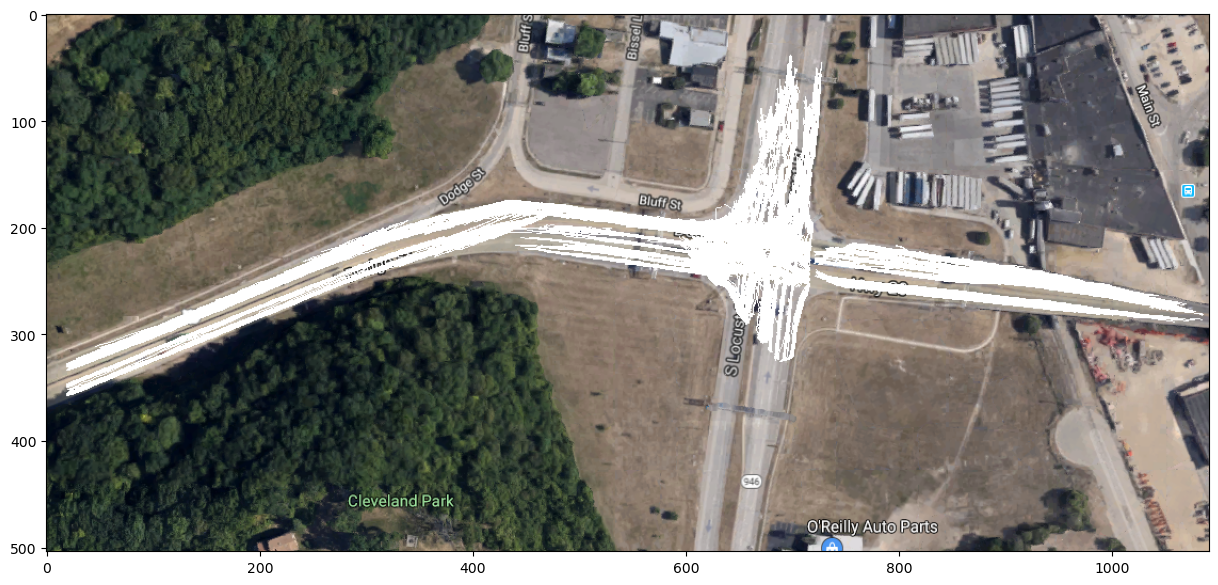

In [8]:
MAP_FILE = 'target_intersection.png'
bg_image = io.imread(MAP_FILE)
scale = (42.489814152793585,-90.67464958318888,42.492905837844546,-90.66237875113197)
img = np.copy(bg_image)
for trajectory in trajectories:
    cv2.polylines(img,np.int32([np.array(trajectory).reshape(-1,1,2)]),False, (255,255,255), 1)

plt.figure(figsize=(15,15))
plt.imshow(img)
# io.imsave('/home/shuo/Shuo/Git-Master/test1.png',bg_image)

## Clustering Step1: 

### Calculate `Hausdroff distance` matrix using scipy library (single thread CPU)

### It took 38454.909 seconds (~10.7 hours) to finish.

In [ ]:
import math
from itertools import combinations_with_replacement
from joblib import Parallel, delayed

def hausforff_distance(u,v):
    return max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()
dmatrix=np.zeros((len(trajectories),len(trajectories)))
count = 0
total = len(trajectories)*len(trajectories)

def compute_single(dmatrix, i, j):
    return hausforff_distance(trajectories[i],trajectories[j])

# out = Parallel(n_jobs=78, verbose=3)(delayed(compute_single)(dmatrix, i, j) for i in range(dmatrix.shape[0]) for j in range(dmatrix.shape[1]))
out = Parallel(n_jobs=10, verbose=3)(delayed(compute_single)(dmatrix, i, j) for i, j in combinations_with_replacement(range(len(trajectories)), 2))
dmatrix = np.asarray(out).reshape((len(trajectories), len(trajectories)))

end = time.time()
print('duration:',end-start)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   38.4s
[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done 492 tasks      | elapsed:  2.7min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  4.2min
[Parallel(n_jobs=10)]: Done 1132 tasks      | elapsed:  6.1min
[Parallel(n_jobs=10)]: Done 1548 tasks      | elapsed:  8.4min
[Parallel(n_jobs=10)]: Done 2028 tasks      | elapsed: 11.0min
[Parallel(n_jobs=10)]: Done 2572 tasks      | elapsed: 13.9min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed: 17.3min
[Parallel(n_jobs=10)]: Done 3852 tasks      | elapsed: 20.9min
[Parallel(n_jobs=10)]: Done 4588 tasks      | elapsed: 24.9min
[Parallel(n_jobs=10)]: Done 5388 tasks      | elapsed: 29.3min
[Parallel(n_jobs=10)]: Done 6252 tasks      | elapsed: 34.0min
[Parallel(n_jobs=10)]: Done 7180 tasks      | 

## Alternative Clustering Step1: 

### Calculate `Hausdroff distance` matrix using cuspatial library (GPU)

#### keep an eye on the speed.

In [12]:
start = time.time()

# Prepare data for GPU
# Concatenating all trajectories
trajs = cp.concatenate([cp.asarray(traj) for traj in trajectories], axis=0)

# `offset` denote the starting index for each trajectory
offsets = cp.asarray([0] + [len(traj) for traj in trajectories]).cumsum()[:-1]

xs = cudf.Series(trajs[:,0])
ys = cudf.Series(trajs[:,1])
offsets = cudf.Series(offsets)

start1 = time.time()
dist=cuspatial.directed_hausdorff_distance(xs, ys, offsets)
end1 = time.time() 
print('\nHausdroff distance calculation by Cuspatial in GPU takes: \n  {0:.3f} seconds (4800X)'.format(end1 - start1))
dmatrix=dist.to_cupy().T.get()
end = time.time()
print('\nThe complete Dmatrix calculation including data transitioning and transforming takes: \n  {0:.3f} seconds (3300X)'.format(end - start))


Hausdroff distance calculation by Cuspatial in GPU takes: 
  10.915 seconds (4800X)

The complete Dmatrix calculation including data transitioning and transforming takes: 
  14.425 seconds (3300X)


In [14]:
start = time.time()
agg = AgglomerativeClustering(n_clusters=10, metric='precomputed', linkage = 'average')
agg_result = agg.fit(dmatrix)
end = time.time()
print('A complete AC search takes:\n  {0:.3f} seconds'.format(end - start))

A complete AC search takes:
  4.385 seconds


In [15]:
start = time.time()
dbscan = DBSCAN(eps=20, metric='precomputed',min_samples=2)
dbscan_result = dbscan.fit(dmatrix)
end = time.time()
print('A complete DBSCAN search takes:\n  {0:.3f} seconds'.format(end - start)) 

A complete DBSCAN search takes:
  1.633 seconds


### Visualize AgglomerativeClustering results (all clusters overlaid, interactive mode)

AgglomerativeClustering
#clusters =  12


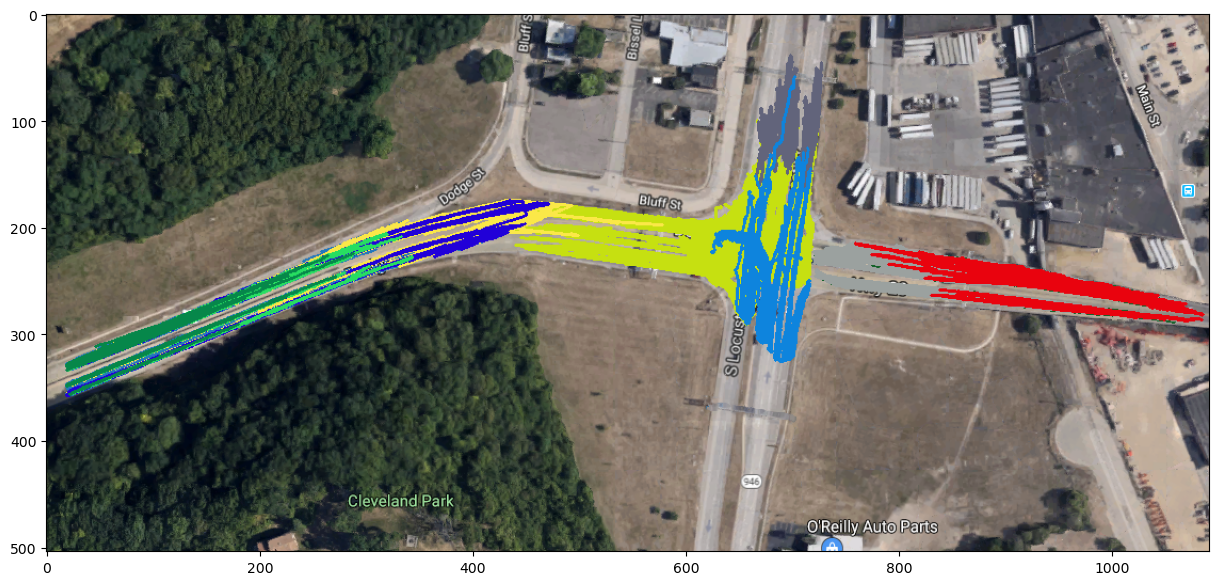

interactive(children=(IntText(value=12, description='n_clusters:'), ToggleButtons(description='linkage:', inde…

<function __main__.visualize_gt_vs_pred(n_clusters, linkage)>

In [16]:
def visualize_gt_vs_pred(n_clusters,linkage):
    print('AgglomerativeClustering')
    agg = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage = linkage)
    agg_result = agg.fit(dmatrix)
    
    labels = agg_result.labels_

    print('#clusters = ',np.max(labels)+1)
    img = np.copy(bg_image)
    for label in range(np.max(labels)+1):

        color = (random.randint(0,255),random.randint(0,255),random.randint(0,255))
        selected_trajectories = pick_traj_with_label(label,labels,trajectories)


        for trajectory in selected_trajectories:
            cv2.polylines(img,np.int32([np.array(trajectory).reshape(-1,1,2)]),False, color, 2)
    plt.figure(figsize=(15,15))
    plt.imshow(img)
    
    
    
interact(visualize_gt_vs_pred,
         n_clusters=widgets.IntText(value=12,description='n_clusters:',disabled=False),
         
         linkage=widgets.ToggleButtons(
                value='average',
                options=['complete', 'average', 'single'],
                description='linkage:',
                disabled=False,
                button_style='', # 'success', 'info', 'warning', 'danger' or ''
            )
        )

### Visualize DBSCAN results (all clusters overlaid, interactive mode)

DBSCAN
#clusters =  8


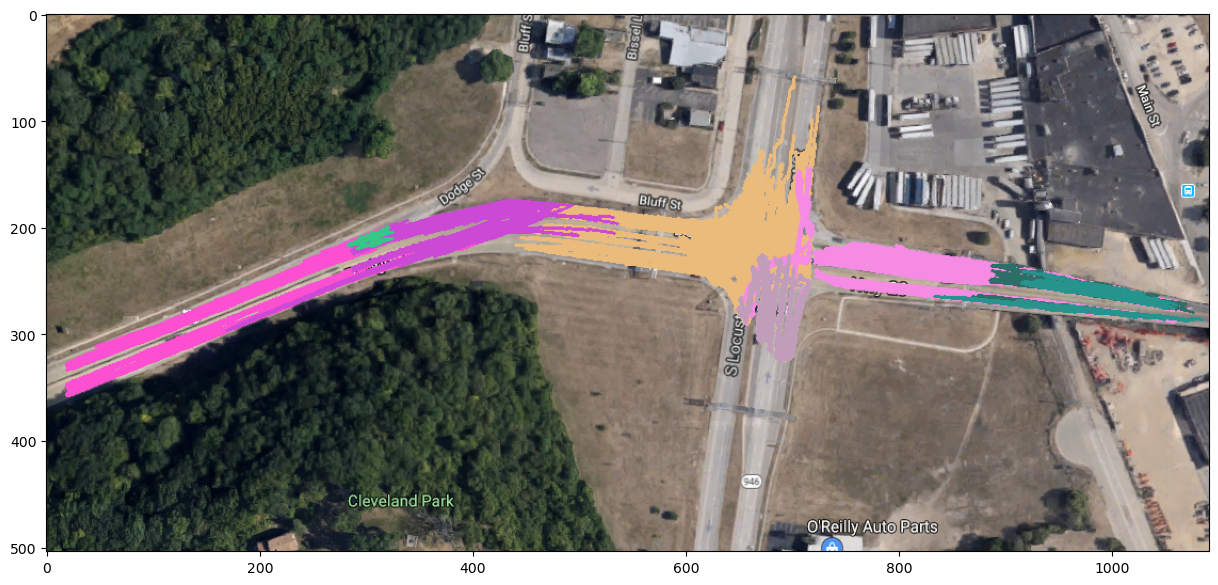

interactive(children=(ToggleButtons(description='eps:', index=7, options=(5, 10, 11, 12, 13, 14, 15, 20, 23, 2…

<function __main__.visualize_gt_vs_pred(eps, min_samples)>

In [17]:
def visualize_gt_vs_pred(eps,min_samples):
    print('DBSCAN')
    dbscan = DBSCAN(eps=eps, metric='precomputed',min_samples=min_samples)
    dbscan_result = dbscan.fit(dmatrix)
    
    labels = dbscan.labels_

    print('#clusters = ',np.max(labels)+1)
    img = np.copy(bg_image)
    for label in range(np.max(labels)+1):

        color = (random.randint(0,255),random.randint(0,255),random.randint(0,255))
        selected_trajectories = pick_traj_with_label(label,labels,trajectories)


        for trajectory in selected_trajectories:
            cv2.polylines(img,np.int32([np.array(trajectory).reshape(-1,1,2)]),False, color, 2)
    plt.figure(figsize=(15,15))
    plt.imshow(img)
    
interact(visualize_gt_vs_pred,
         min_samples=widgets.IntText(value=600,description='min_samples:',disabled=False),
         
         eps=widgets.ToggleButtons(
                value=20,
                options=[5,10,11,12,13,14,15,20,23,27,30],
                description='eps:',
                disabled=False,
                button_style='', # 'success', 'info', 'warning', 'danger' or ''
            )
        )

### Visualize AgglomerativeClustering results (clusters in separate subplots, interactive mode)

AgglomerativeClustering
#clusters =  12


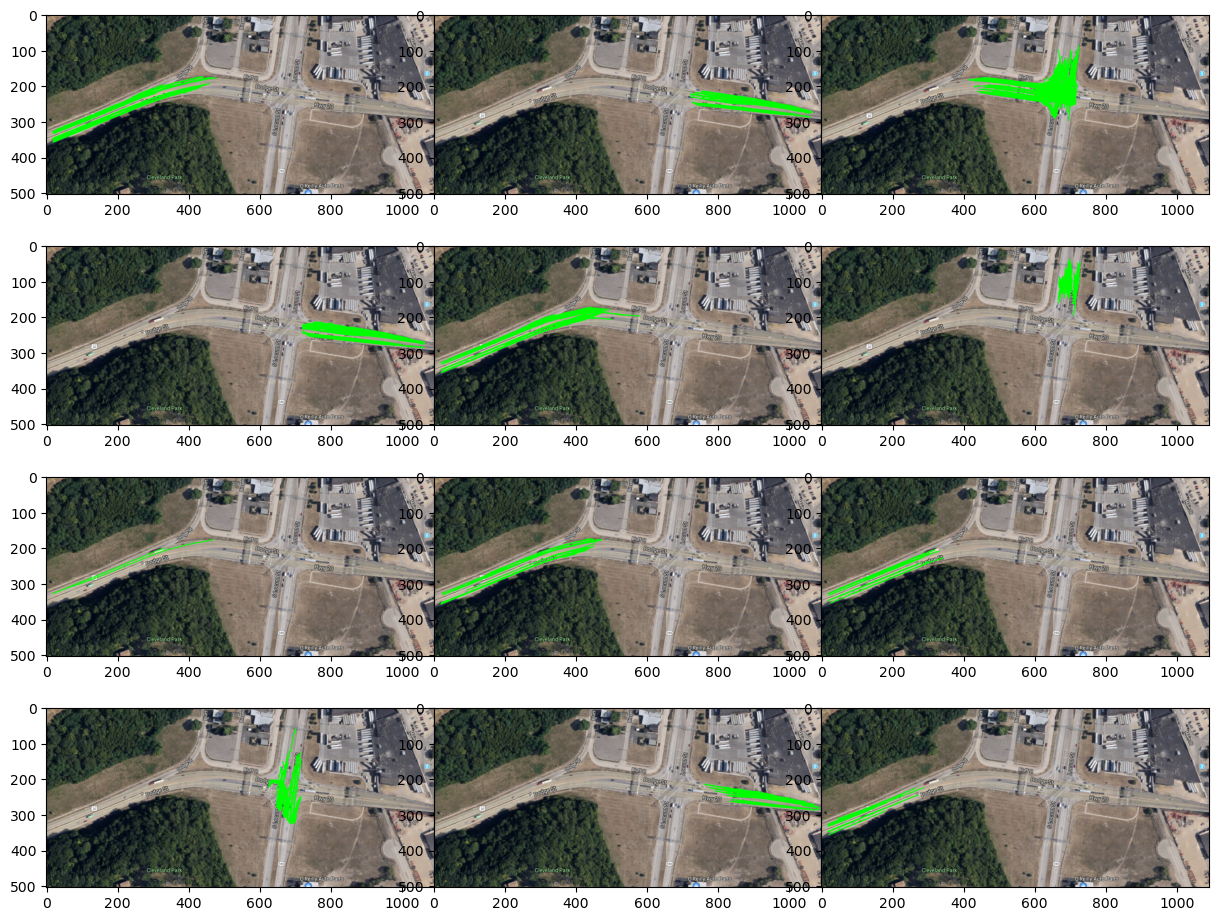

interactive(children=(IntText(value=12, description='n_clusters:'), ToggleButtons(description='linkage:', inde…

<function __main__.visualize_gt_vs_pred(n_clusters, linkage)>

In [18]:
def visualize_gt_vs_pred(n_clusters,linkage):
    print('AgglomerativeClustering')
    agg = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage = linkage)
    agg_result = agg.fit(dmatrix)
    
    labels = agg_result.labels_

    print('#clusters = ',np.max(labels)+1)
    
    
    plt.figure(figsize=(15,15))
    gs = gridspec.GridSpec(5, int(np.ceil(n_clusters/5)) , wspace=0, hspace=0)
    idx = 0
    for label in range(np.max(labels)+1):
        
        ax = plt.subplot(gs[idx])
        idx+=1
        img = np.copy(bg_image)
#         color = (random.randint(0,255),random.randint(0,255),random.randint(0,255))
        color = (0,255,0)
        selected_trajectories = pick_traj_with_label(label,labels,trajectories)


        for trajectory in selected_trajectories:
            cv2.polylines(img,np.int32([np.array(trajectory).reshape(-1,1,2)]),False, color, 2)
    
        plt.imshow(img)
    
interact(visualize_gt_vs_pred,
         n_clusters=widgets.IntText(value=12,description='n_clusters:',disabled=False),
         
         linkage=widgets.ToggleButtons(
                value = 'average',
                options=['complete', 'average', 'single'],
                description='linkage:',
                disabled=False,
                button_style='', # 'success', 'info', 'warning', 'danger' or ''
            )
        )

### Visualize DBSCAN results (clusters in separate subplots, interactive mode)

DBSCAN
#clusters =  8


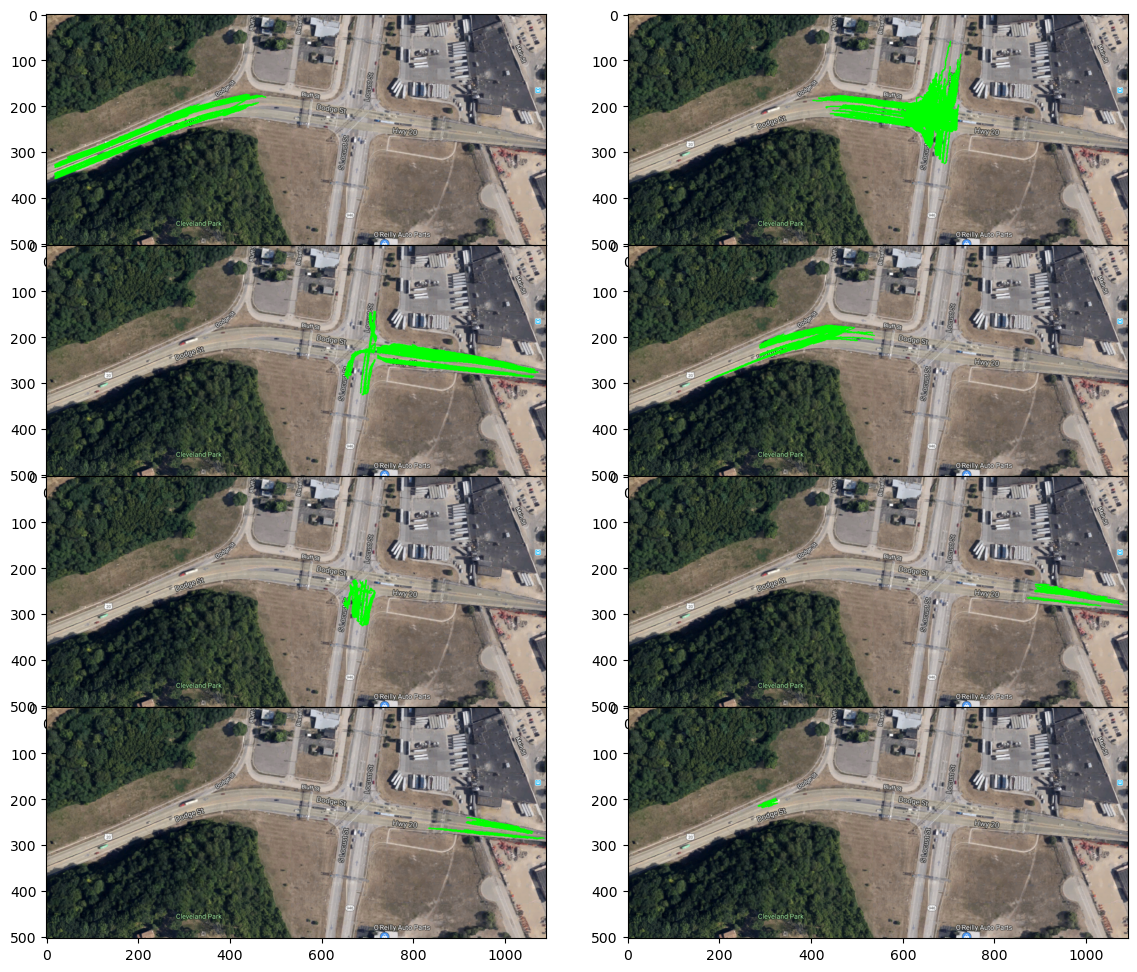

interactive(children=(ToggleButtons(description='eps:', index=6, options=(5, 10, 12, 13, 14, 15, 20, 25, 30), …

<function __main__.visualize_gt_vs_pred(eps, min_samples)>

In [21]:

def visualize_gt_vs_pred(eps,min_samples):
    print('DBSCAN')
    dbscan = DBSCAN(eps=eps, metric='precomputed',min_samples=min_samples)
    dbscan_result = dbscan.fit(dmatrix)
    
    labels = dbscan_result.labels_

    print('#clusters = ',np.max(labels)+1)
    
    
    plt.figure(figsize=(15,15))
    gs = gridspec.GridSpec(5, int(np.ceil((np.max(labels)+1)/5)) , wspace=0, hspace=0)
    idx = 0
    for label in range(np.max(labels)+1):
        
        ax = plt.subplot(gs[idx])
        idx+=1
        img = np.copy(bg_image)
#         color = (random.randint(0,255),random.randint(0,255),random.randint(0,255))
        color = (0,255,0)
        selected_trajectories = pick_traj_with_label(label,labels,trajectories)


        for trajectory in selected_trajectories:
            cv2.polylines(img,np.int32([np.array(trajectory).reshape(-1,1,2)]),False, color, 2)
    
        plt.imshow(img)
    
interact(visualize_gt_vs_pred,
         min_samples=widgets.IntText(value=600,description='min_samples:',disabled=False),
         
         eps=widgets.ToggleButtons(
                value=20,
                options=[5,10,12,13,14,15,20,25,30],
#                 options=[5,10,11,12,13,14,15,20,30],
                description='eps:',
                disabled=False,
                button_style='', # 'success', 'info', 'warning', 'danger' or ''
            )
        )